# Backprojection

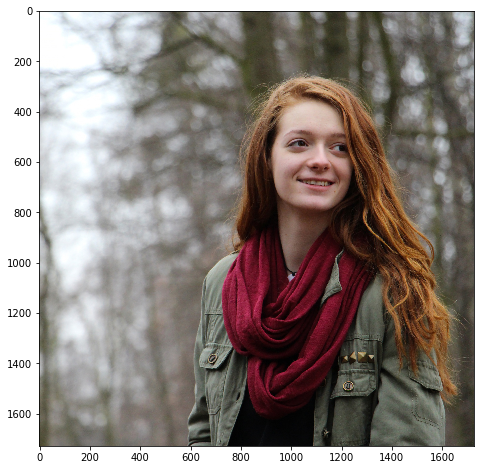

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('face.jpg')[:,:,::-1]
#img = cv2.resize(img, (img.shape[1]//2, img.shape[1]//2))
plt.figure(figsize=[8,8])
plt.imshow(img)

### Convert image to the HSV color space

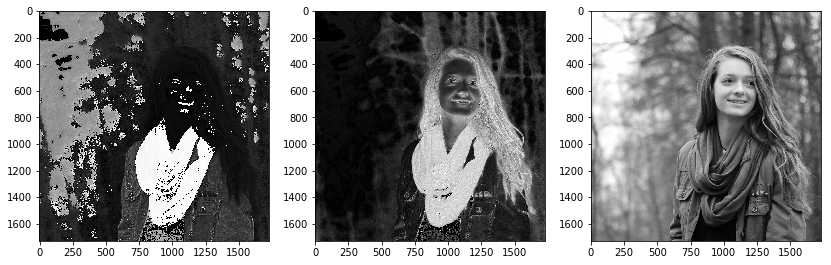

In [11]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.figure(figsize=[14, 10])
plt.subplot(1, 3, 1)
plt.imshow(img_hsv[:,:,0], 'gray')
plt.subplot(1, 3, 2)
plt.imshow(img_hsv[:,:,1], 'gray')
plt.subplot(1, 3, 3)
plt.imshow(img_hsv[:,:,2], 'gray')

### Select region of interest

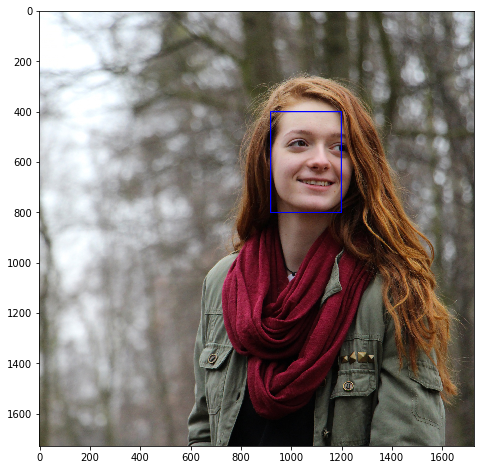

In [12]:
pt1 = [920, 400]
pt2 = [1200, 800]
obj_bounds = np.array([[pt1[0], pt1[1]], [pt2[0], pt1[1]], [pt2[0], pt2[1]] , [pt1[0], pt2[1]]], dtype=np.int32)
img_obj = cv2.polylines(img.copy(), [obj_bounds], True, (0, 0, 255), 3, cv2.LINE_AA)

plt.figure(figsize=[8,8])
plt.imshow(img_obj, 'gray')

### Calculate n-dimensional histogram of image

The number of dimensions n of the histogram is equal to the number of channels in the image

Text(0, 0.5, 'Hue')

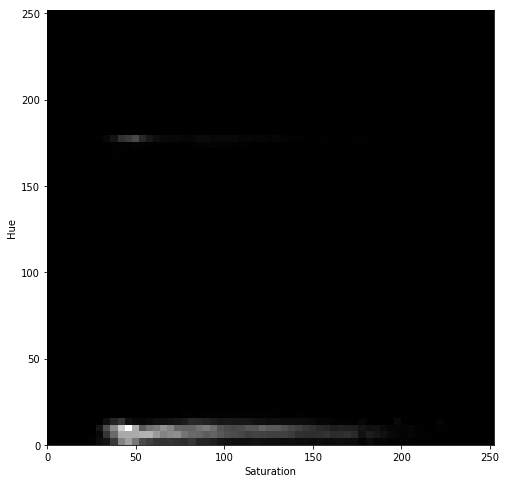

In [13]:
def calculate_histogram(img, bins):
    
    num_channels = img.shape[2]
    # np.histogramdd expects a Nxk array where N is the number of pixels and k the number of channels
    obj_data = np.zeros((img_obj.shape[0]*img_obj.shape[1], 
                         num_channels), dtype=np.uint8)
    for i in range(num_channels):
        obj_data[:,i] = img_obj[:,:,i].flatten()
        
    hist, bins = np.histogramdd(obj_data, [bins]*num_channels)
    
    return hist, bins

# Use only Hue and Saturation channels
img_hs = img_hsv[:,:,:2]
img_obj = img_hs[pt1[1]:pt2[1], pt1[0]:pt2[0]]   # Region of interest
bins = np.arange(0, 255+4, 4)
hist, bins = calculate_histogram(img_obj, bins)

plt.figure(figsize=[8,8])
plt.pcolormesh(bins[0][:-1], bins[1][:-1], hist, cmap='gray')
plt.xlabel('Saturation')
plt.ylabel('Hue')

## Apply backprojection

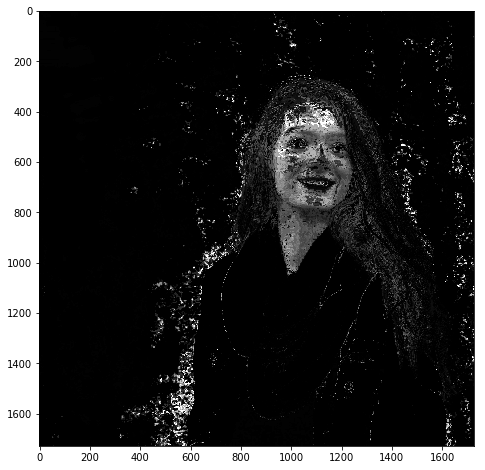

In [15]:
def backprojection(img, probs, bins):
        
    num_rows, num_cols, num_channels = img.shape
    img_probs = np.zeros((num_rows, num_cols))
    for row in range(num_rows):
        for col in range(num_cols):
            vals = img[row, col]
            coords = get_coordinates(vals, bins)
            img_probs[row, col] = probs[tuple(coords)]
            
    return img_probs

def get_coordinates(vals, bins):
    '''Get the bin index of each value in array vals. For instance, if bins[0] is [1, 3, 5, 7, 9]
       and vals[0] is 6, then coords[0] will be equal to 2.'''
    
    coords = []
    for channel, val in enumerate(vals):
        min_value = bins[channel][0]
        bin_width = bins[channel][1]-min_value
        bin_index = int((val-min_value)/bin_width)
        coords.append(bin_index)
        
    return coords


img_probs = backprojection(img_hs, hist, bins)        

plt.figure(figsize=[8,8])
plt.imshow(img_probs, 'gray')